# W jet study

In [3]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
# from tensorflow.keras.layers import Conv1D
# from tensorflow.keras.layers import Flatten, Reshape, Lambda
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import Model

import os
import os.path as osp
import sys

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools_W_test
from utils.VAE_model_tools_W_test import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle
from scipy.stats import gaussian_kde

1 Physical GPUs, 0 Logical GPUs


In [4]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

def ptetaphiE_to_Epxpypz(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = E
    newjets[:,:,1] = px
    newjets[:,:,2] = py
    newjets[:,:,3] = pz
    
    return newjets

def Epxpypz_to_ptetaphiE(jets):
    E = jets[:,:,0]
    px = jets[:,:,1]
    py = jets[:,:,2]
    pz = jets[:,:,3]
    
    pt = np.sqrt(np.square(px) + np.square(py))
    phi = np.arctan2(py,px)
    eta = np.arcsinh(pz/pt)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = eta
    newjets[:,:,2] = phi
    newjets[:,:,3] = E
    
def ptetaphiE_to_ptyphim(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    pz = pt * np.sinh(eta)
    y = 0.5*np.nan_to_num(np.log((E+pz)/(E-pz)))
    
    msqr = np.square(E)-np.square(pt)-np.square(pz)
    msqr[np.abs(msqr) < 1e-6] = 0
    m = np.sqrt(msqr)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = y
    newjets[:,:,2] = phi
    newjets[:,:,3] = m
    
    return newjets
    
def ptyphim_to_ptetaphiE(jets):
    
    pt = jets[:,:,0]
    y = jets[:,:,1]
    phi = jets[:,:,2]
    m = jets[:,:,3]
    
    eta = np.nan_to_num(np.arcsinh(np.sinh(y)*np.sqrt(1+np.square(m/pt))))
    pz = pt * np.sinh(eta)
    E = np.sqrt(np.square(pz)+np.square(pt)+np.square(m))
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = eta
    newjets[:,:,2] = phi
    newjets[:,:,3] = E
    
    return newjets
    
def center_jets_ptetaphiE(jets):
    cartesian_jets = ptetaphiE_to_Epxpypz(jets)
    sumjet_cartesian = np.sum(cartesian_jets,axis=1)
    
    sumjet_phi = np.arctan2(sumjet_cartesian[:,2],sumjet_cartesian[:,1])
    sumjet_y = 0.5*np.log((sumjet_cartesian[:,0] + sumjet_cartesian[:,-1])/(sumjet_cartesian[:,0] - sumjet_cartesian[:,-1]))
    
    ptyphim_jets = ptetaphiE_to_ptyphim(jets)
    #print(ptyphim_jets[:3,:,:])
    
    transformed_jets = np.copy(ptyphim_jets)
    transformed_jets[:,:,1] = ptyphim_jets[:,:,1] - sumjet_y[:,None]
    transformed_jets[:,:,2] = ptyphim_jets[:,:,2] - sumjet_phi[:,None]
    transformed_jets[:,:,2] = transformed_jets[:,:,2] + np.pi
    transformed_jets[:,:,2] = np.mod(transformed_jets[:,:,2],2*np.pi)
    transformed_jets[:,:,2] = transformed_jets[:,:,2] - np.pi

    transformed_jets[transformed_jets[:,:,0] == 0] = 0
    
    newjets = ptyphim_to_ptetaphiE(transformed_jets)
    return newjets
    
def kl_loss(z_mean, z_log_var):
    return -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    
    
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
#     phis = [jet.phi for jet in jets]
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis


def plot_jets(outs_array, numplot = 3, R=0.02,size=50):
    etalim=5
    #bins=np.linspace(-lim, lim, 126)

    for i in range(numplot):   

        fig, ax = plt.subplots(1, 3,figsize=[15,5],sharey=True)



        outjet = valid_y[i,:,1:]
        weights = valid_y[i,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
        ax[0].scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
        ax[0].set_title('Jet'+str(i),y=0.9)

        #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
        for j in range(2):
            outjet = outs_array[j][0][i,:,1:]
            weights = outs_array[j][0][i,:,0]
            pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
            ax[j+1].scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
            ax[j+1].set_title('Sample'+ str(j),y=0.9)
            
        for j in range(3):
            ax[j].set_ylabel(r'$\eta$',fontsize=18)
            ax[j].set_xlabel(r'$\phi$',fontsize=18)
            ax[j].set_ylim([-0.7,0.7])
            ax[j].set_xlim([-0.7,0.7])

        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
def plot_KL_logvar(outs_array,xlim=None,ylim=None,
                  showhist=False, numhists=10,hist_ylim=None,hist_xlim=None):
    
    _, z_mean, z_log_var, z = outs_array[0]

    KL=kl_loss(z_mean, z_log_var)
    sort_kl = np.flip(np.argsort(np.mean(KL,axis=0)))

    rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

    plt.scatter(np.mean(KL,axis=0),rms_mean,s=5.)

    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
        
    plt.xlabel('KL divergence')
    plt.ylabel(r'$\sqrt{\left\langle \mu^2 \right\rangle}$')
    plt.show()
    
    if showhist:
#         for i in range(10):
        xmax = 20
        if hist_xlim is not None:
            plt.xlim(hist_xlim)
            xmax = hist_xlim[1]
        plt.hist(np.array(KL)[:,sort_kl[:numhists]],bins=np.linspace(0,xmax,80),stacked=True)

        if hist_ylim is not None:
            plt.ylim(hist_ylim)

        plt.show()     

    return sort_kl



### Define VAE

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

In [5]:
# path to file
fn =  '/home/jcollins/projects/EMD_VAE/in_data/monoW-data-3.h5'
# fn =  '/media/jcollins/MAGIC!/monoW-data-3.h5'

# Option 1: Load everything into memory
df = pandas.read_hdf(fn,stop=100000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

(100000, 200)
Memory in GB: 0.2995133399963379


In [6]:
data = df.values.reshape((-1,50,4))
jets = data

cartesian_jets = ptetaphiE_to_Epxpypz(jets)
sumjet_cartesian = np.sum(cartesian_jets,axis=1)

E = sumjet_cartesian[:,0]
pt = np.sqrt(np.square(sumjet_cartesian[:,1]) + np.square(sumjet_cartesian[:,2]))

ptp = 550.

beta = (E*pt - ptp*np.sqrt(np.square(E) - np.square(pt) + np.square(ptp)))/(np.square(E) + np.square(ptp))

# sumjet_phi = np.arctan2(sumjet_cartesian[:,2],sumjet_cartesian[:,1])
# sumjet_y = 0.5*np.log((sumjet_cartesian[:,0] + sumjet_cartesian[:,-1])/(sumjet_cartesian[:,0] - sumjet_cartesian[:,-1]))

# ptyphim_jets = ptetaphiE_to_ptyphim(jets)
# #print(ptyphim_jets[:3,:,:])

# transformed_jets = np.copy(ptyphim_jets)
# transformed_jets[:,:,1] = ptyphim_jets[:,:,1] - sumjet_y[:,None]
# transformed_jets[:,:,2] = ptyphim_jets[:,:,2] - sumjet_phi[:,None]
# transformed_jets[:,:,2] = transformed_jets[:,:,2] + np.pi
# transformed_jets[:,:,2] = np.mod(transformed_jets[:,:,2],2*np.pi)
# transformed_jets[:,:,2] = transformed_jets[:,:,2] - np.pi

# transformed_jets[transformed_jets[:,:,0] == 0] = 0

# newjets = ptyphim_to_ptetaphiE(transformed_jets)

In [7]:
# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi, E.
data = df.values.reshape((-1,50,4))

# Normalize pTs so that HT = 1
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]
data[:,:,-1] = data[:,:,-1]/HT[:,None]

# Center jet (optional)
data = center_jets_ptetaphiE(data)

# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),50,5))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data[:,:,:3]


train_x = data_x[:50000]
train_y = data_y[:50000]
valid_x = data_x[50000:]
valid_y = data_y[50000:]

<ipython-input-4-58f45c1c3b36>:52: RuntimeWarning: invalid value encountered in true_divide
  y = 0.5*np.nan_to_num(np.log((E+pz)/(E-pz)))
<ipython-input-4-58f45c1c3b36>:73: RuntimeWarning: invalid value encountered in true_divide
  eta = np.nan_to_num(np.arcsinh(np.sinh(y)*np.sqrt(1+np.square(m/pt))))


In [8]:
experiment_name = 'W-test'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1),
                                    encoder_conv_layers = [2048,2048,1028,1024],
                                    dense_size = [1028,1028,1028,512],
                                    decoder = [4026,2048,1028,512,512],
                                    numItermaxinner = 10,
                                    numIter=10,
                                    reg_init = 1.,
                                    reg_final = 0.01,
                                    stopThr=1e-3,
                                    num_inputs=5,
                                    num_particles_in=50,
                                                       verbose=2,
                                                       dropout=0)

batch_size=10
save_period=2

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*5000, save_weights_only=True)
reset_metrics_inst = reset_metrics()

callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,
            modelcheckpoint,
            reset_metrics_inst]

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 2048)     12288       inputs[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 50, 2048)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 2048)     4196352     re_lu[0][0]                      
_____

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 2048)     12288       inputs[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 50, 2048)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 2048)     4196352     re_lu[0][0]                      
________________________________________________________________________________________________

In [9]:
batch_size=10
save_period=2
callbacks=[]

vae.beta.assign(0.01)
numbatches = 5000

K.set_value(vae.optimizer.lr,1e-4)
epochs = 1000


history = vae.fit(x=train_x[:10], y=train_y[:10], batch_size=10,
                epochs=1,verbose=1,#initial_epoch=int(vae.optimizer.iterations/numbatches),
                #validation_data = (valid_x[:10*batch_size],valid_y[:10*batch_size]),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

1/1 [==============================] - 0s 770us/step - loss: 9441.9443 - recon_loss: 1.8140 - KL loss: 371.7038 - beta: 0.0100


Loss: 2.37e+01
Recon loss: 6.31e-04
KL loss: 11.126871

Epoch 601, beta = 5e-3
I deleted a lot of the early model files to save space, so we get to see the NN after already a lot of training
At this point, the NN understands four latent directions, as seen in the plots below
KL divergences plot. x axis is ~ log(resolution) for resolution << 1


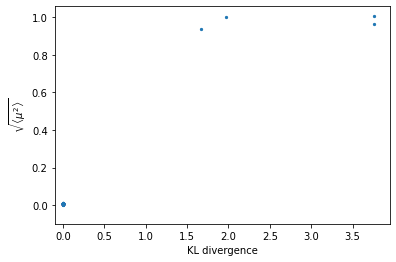

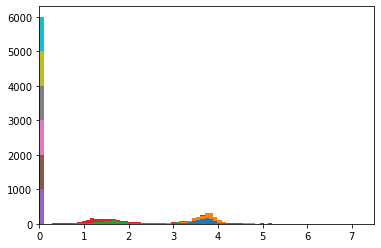

Jet sample plots. Left = original jet. Middle and right: two vae samples


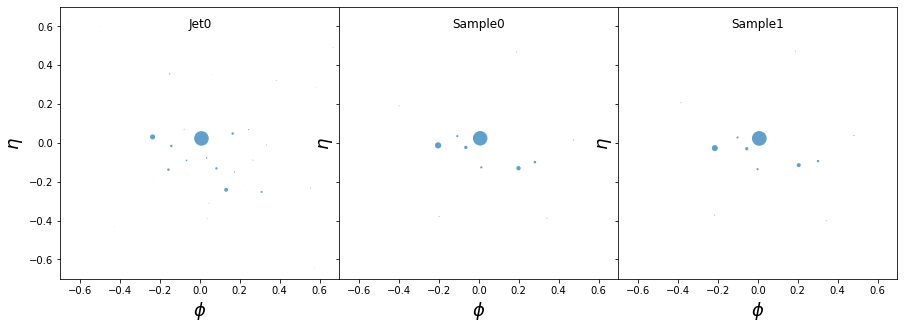

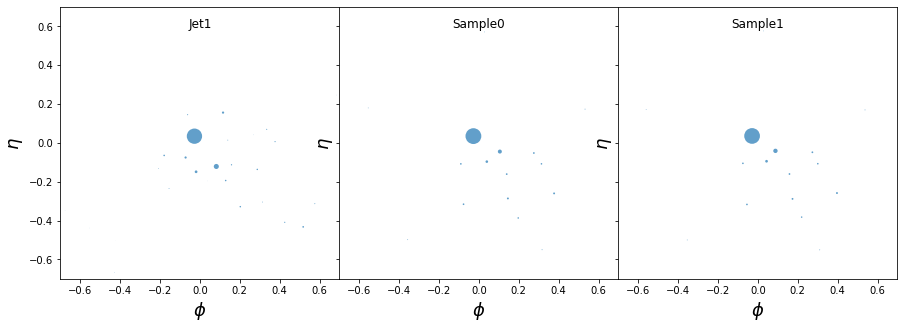

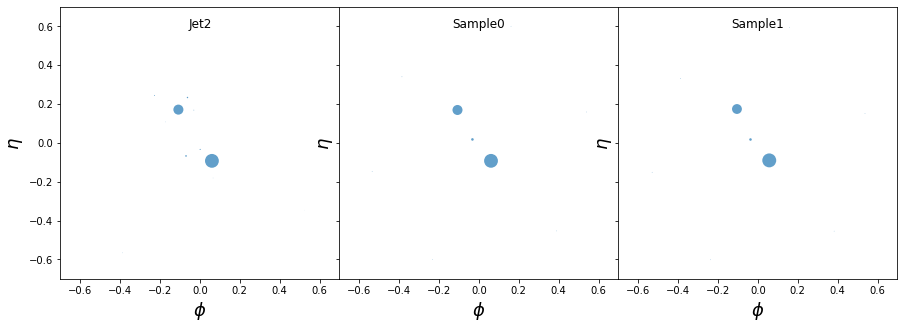

Latent space distributions in most important latent space directions


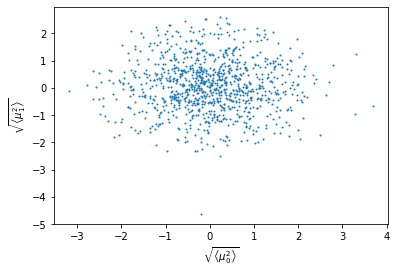

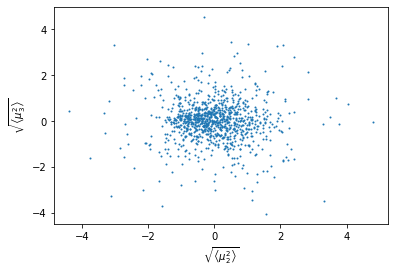

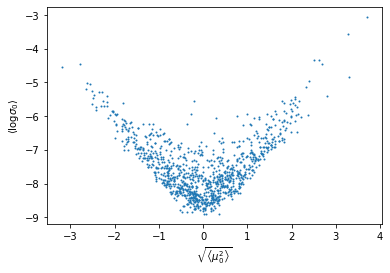

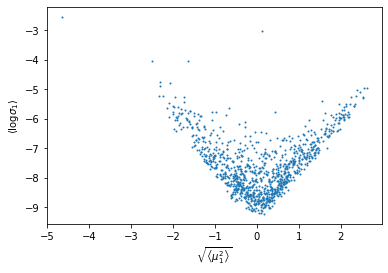

Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond 

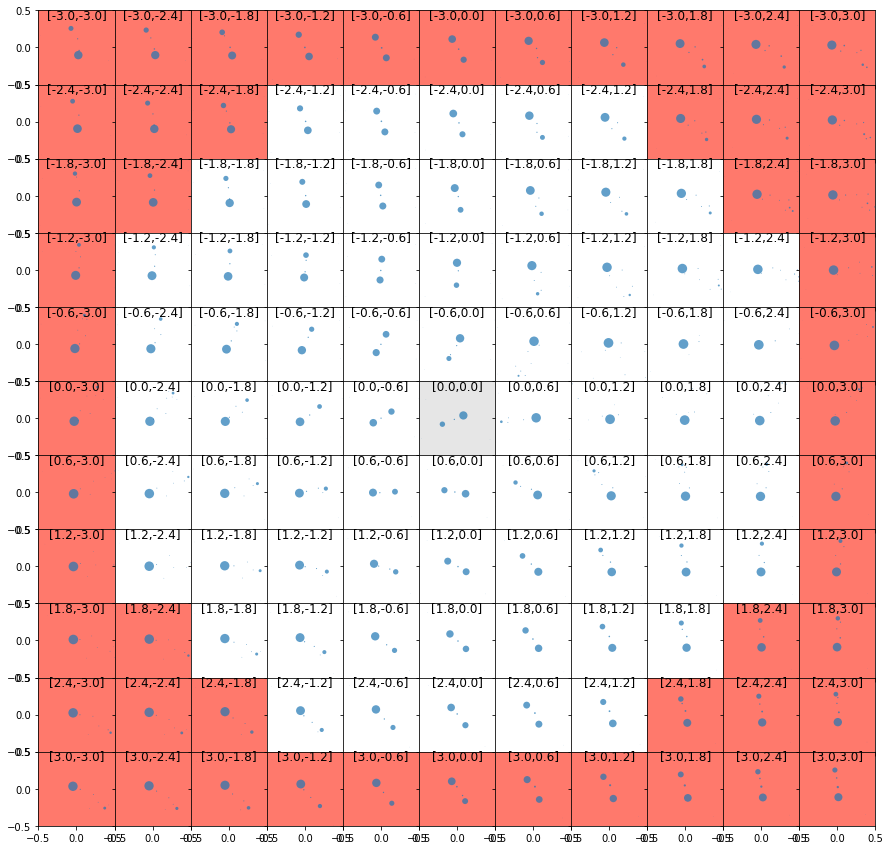

Next two latent directions. It seems that these describe a third emission. Radius in this plane is something like three-jettiness (2-jetty in the middle, three-jetty towards rim), and the angle in the plane represents the direction of the third emission.


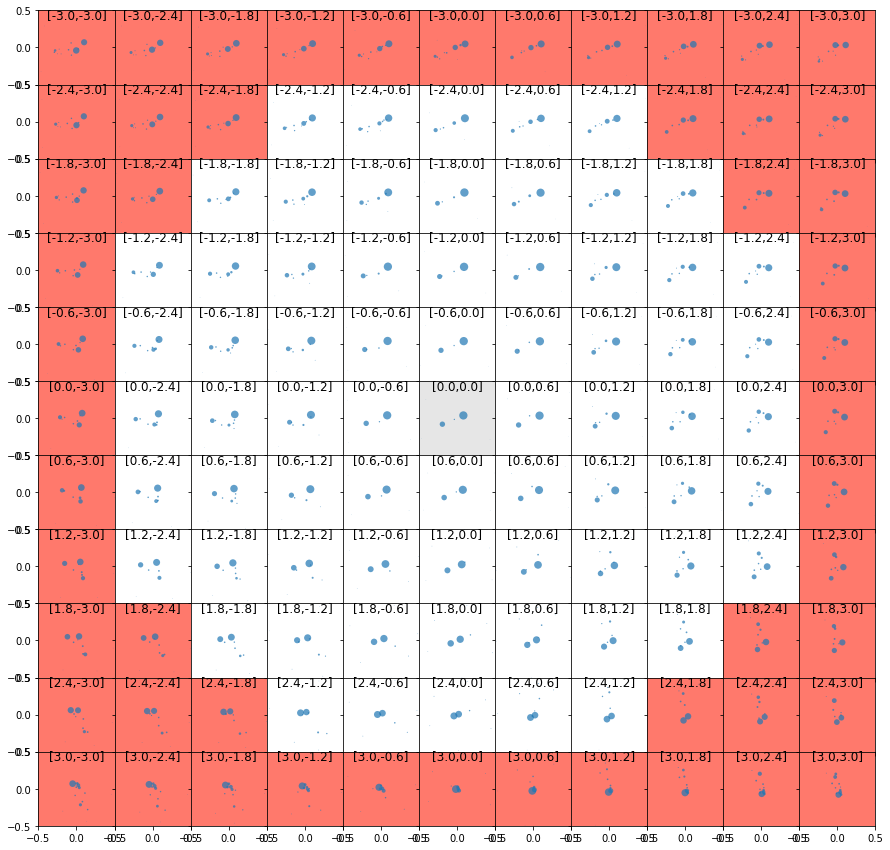

In [11]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_601_0.005.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

vae.beta.assign(5e-3)
result = vae.test_step([valid_x[:2000].astype(np.float32),valid_y[:2000].astype(np.float32)])

print("Loss:", "{:.02e}".format(result['loss'].numpy()))
print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
print("KL loss:", result['KL loss'].numpy())

print()

print("Epoch 601, beta = 5e-3")
print("I deleted a lot of the early model files to save space, so we get to see the NN after already a lot of training")
print("At this point, the NN understands four latent directions, as seen in the plots below")

print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None],
                         showhist=True,hist_xlim=[None,7.5])

print("Jet sample plots. Left = original jet. Middle and right: two vae samples")
plot_jets(outs_array,R=0.05,size=300)

print("Latent space distributions in most important latent space directions")
_, z_mean, z_log_var, z = outs_array[0]

plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()
plt.scatter(z_mean[:,sort_kl[2]],z_mean[:,sort_kl[3]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_2^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_3^2 \right\rangle}$')
plt.show()

plt.scatter(z_mean[:,sort_kl[0]],z_log_var[:,sort_kl[0]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_0 \right\rangle$')
plt.show()
plt.scatter(z_mean[:,sort_kl[1]],z_log_var[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_1 \right\rangle$')
plt.show()

print("Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond to latent points that are close in the latent space, except at the rim of the disk where a small change in real space can take you straight to the opposite edge of the disk. As the resolution of the VAE gets finer and finer, this affects a smaller and smaller annulus of jets around the rim of the disk.")

narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


print("Next two latent directions. It seems that these describe a third emission. Radius in this plane is something like three-jettiness (2-jetty in the middle, three-jetty towards rim), and the angle in the plane represents the direction of the third emission.")
codes = np.zeros((narray**2,128))
dirs = [2,3]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.025)
        x=codes[narray*i+j,sort_kl[2]]
        y=codes[narray*i+j,sort_kl[3]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

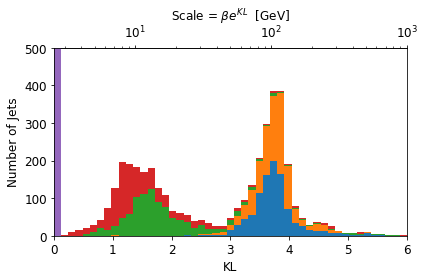

In [12]:
beta = 5e-3

_, z_mean, z_log_var, z = outs_array[0]

KL=kl_loss(z_mean, z_log_var)
sort_kl = np.flip(np.argsort(np.mean(KL,axis=0)))

rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

# plt.scatter(np.mean(KL,axis=0),rms_mean,s=5.)
# if ylim:
#     plt.ylim(ylim)
# if xlim:
#     plt.xlim(xlim)

# plt.xlabel('KL divergence')
# plt.ylabel(r'$\sqrt{\left\langle \mu^2 \right\rangle}$')
# plt.show()

fig = plt.figure()

hist_xlim=[None,6]
hist_ylim=[None,500]
numhists = 10
xmax = 20
if hist_xlim is not None:
    plt.xlim(hist_xlim)
    xmax = hist_xlim[1]
plt.hist(np.array(KL)[:,sort_kl[:numhists]],bins=np.linspace(0,xmax,50),stacked=True)

if hist_ylim is not None:
    plt.ylim(hist_ylim)
    
def KL_to_scale(KL):
    return 500*beta*np.exp(KL)

def scale_to_KL(scale):
    return np.log(scale/500./beta)
    
ax = fig.axes[0]
sec_ax = ax.secondary_xaxis('top',
                            functions=(KL_to_scale,scale_to_KL))
sec_ax.set_xscale("log")
sec_ax.set_xlabel(r"Scale = $\beta e^{KL}$  [GeV]",fontsize=12)
sec_ax.tick_params(labelsize=12)
ax.tick_params(labelsize=12)
ax.set_xlabel(r"KL",fontsize=12)
plt.ylabel('Number of Jets',fontsize=12)
plt.tight_layout()
plt.savefig('KL_hist.png',transparent = False,facecolor='white')
plt.show()     

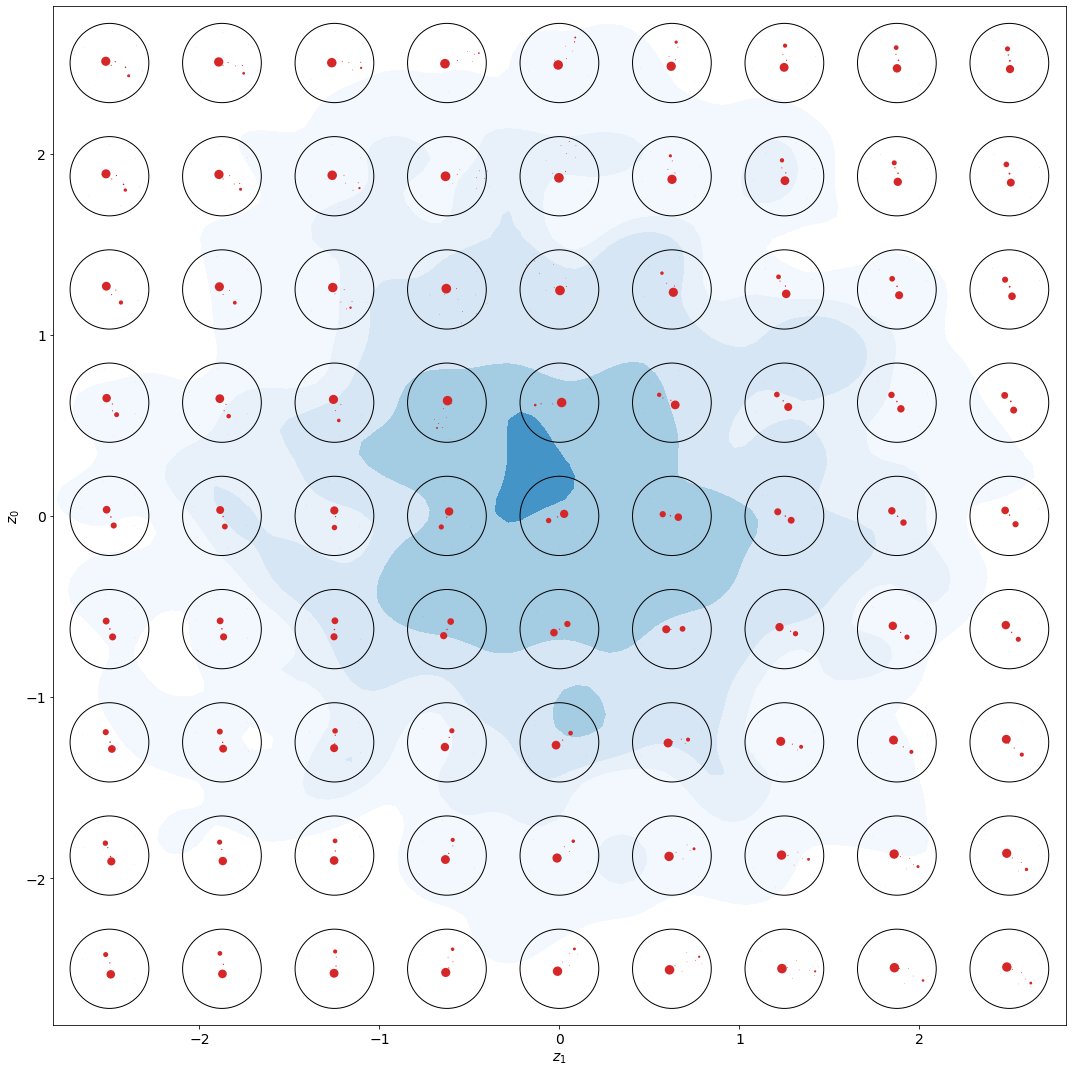

In [15]:
outs_array = [vae.predict(valid_x[:10000]) for j in range(0)]

narray = 9
lim = 2.5
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

# fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)
fig = plt.figure(figsize=[15,15])

circles = [[plt.Circle((i*2/(narray-1)*lim-lim, j*2/(narray-1)*lim-lim), 0.7/(narray-1)*lim,
                       color='black',#[0.8,0.8,0.8],
                       fill=False) for j in range(narray)] for i in range(narray)]

this = gaussian_kde([z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]]],bw_method=0.15)
xmin=-3.1
xmax=3.1
ymin=-3.1
ymax=3.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(this(positions).T, X.shape)
plt.contourf(np.rot90(X),np.rot90(Y),np.rot90(Z),[0.01,0.03,0.05,0.1,0.2,0.3],cmap='Blues',
             vmax=0.4)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.075)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        
        

        #         if np.square(x) + np.square(y) > np.square(2.7):
#             ax[i,j].set_facecolor('xkcd:salmon')
#         if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
#             ax[i,j].set_facecolor('xkcd:salmon')
        plt.scatter((phis + 2.*i)/(narray-1)*lim-lim, (etas+2.*j)/(narray-1)*lim-lim,
                    s = pts*100, alpha = 1.,linewidths=0,color='tab:red')

        plt.gcf().gca().add_artist(circles[i][j])
#         ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',

#         ax[j,i].set_aspect('equal')

# ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.xlim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])
plt.ylim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
plt.tick_params(labelsize=14)
plt.xlabel(r'$z_1$',fontsize=14)
plt.ylabel(r'$z_0$',fontsize=14)
plt.tight_layout()
plt.savefig('jetarray_01.png',transparent = False,facecolor='white')
plt.show()

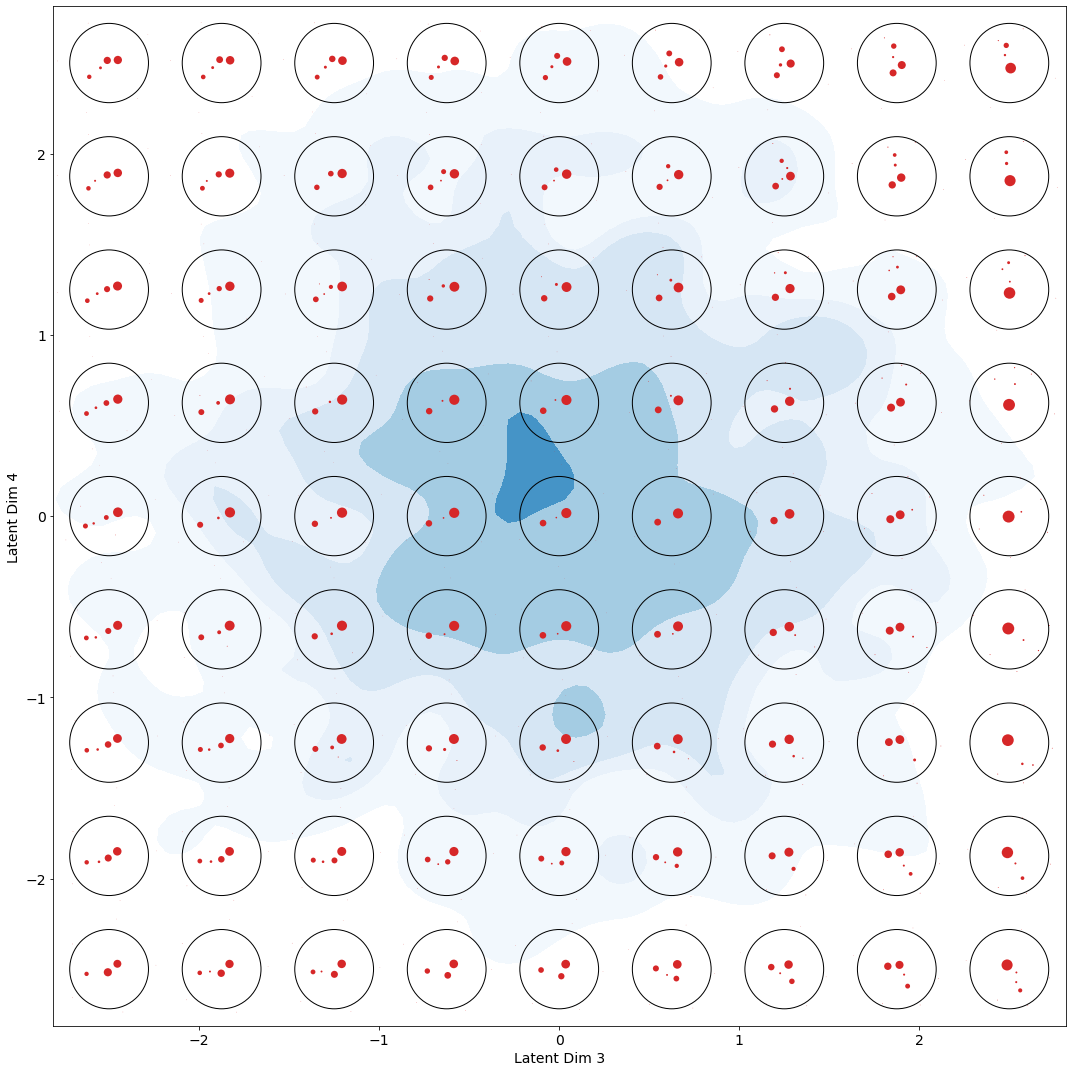

In [62]:
outs_array = [vae.predict(valid_x[:10000]) for j in range(0)]

narray = 9
lim = 2.5
codes = np.zeros((narray**2,128))

dirs = [2,3]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

# fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)
fig = plt.figure(figsize=[15,15])

circles = [[plt.Circle((i*2/(narray-1)*lim-lim, j*2/(narray-1)*lim-lim), 0.7/(narray-1)*lim,
                       color='black',#[0.8,0.8,0.8],
                       fill=False) for j in range(narray)] for i in range(narray)]

this = gaussian_kde([z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]]],bw_method=0.15)
xmin=-3.1
xmax=3.1
ymin=-3.1
ymax=3.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(this(positions).T, X.shape)
plt.contourf(np.rot90(X),np.rot90(Y),np.rot90(Z),[0.01,0.03,0.05,0.1,0.2,0.3],cmap='Blues',
             vmax=0.4)
zoom=1.5
for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.1)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        
        

        #         if np.square(x) + np.square(y) > np.square(2.7):
#             ax[i,j].set_facecolor('xkcd:salmon')
#         if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
#             ax[i,j].set_facecolor('xkcd:salmon')
        plt.scatter((phis*zoom + 2.*i)/(narray-1)*lim-lim, (etas*zoom+2.*j)/(narray-1)*lim-lim,
                    s = pts*150, alpha = 1.,linewidths=0,color='tab:red')

        plt.gcf().gca().add_artist(circles[i][j])
#         ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',

#         ax[j,i].set_aspect('equal')

# ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.xlim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])
plt.ylim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
plt.tick_params(labelsize=14)
plt.xlabel("Latent Dim 3",fontsize=14)
plt.ylabel('Latent Dim 4',fontsize=14)
plt.tight_layout()
plt.savefig('jetarray_23.png',transparent = False,facecolor='white')
plt.show()

### Epoch 601, beta = 5e-3

Loss: 9.67e+01
Recon loss: 2.13e-03
KL loss: 11.45884

Epoch 601, beta = 5e-3
I deleted a lot of the early model files to save space, so we get to see the NN after already a lot of training
At this point, the NN understands four latent directions, as seen in the plots below
KL divergences plot. x axis is ~ log(resolution) for resolution << 1


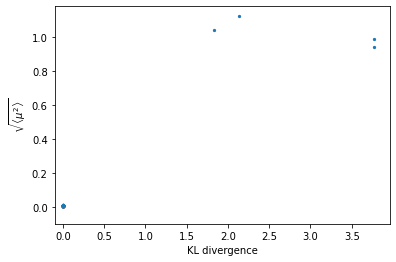

Jet sample plots. Left = original jet. Middle and right: two vae samples


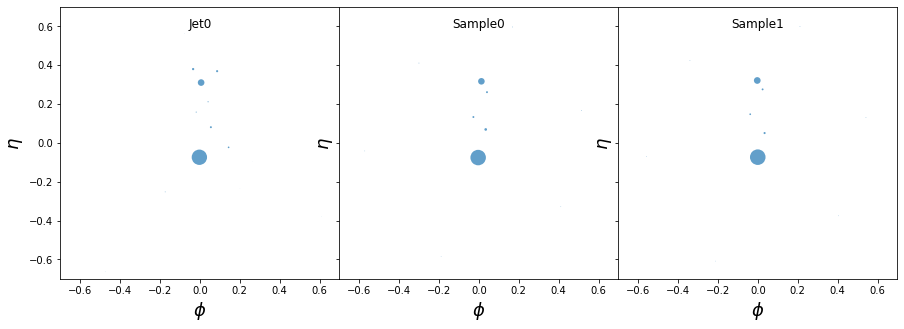

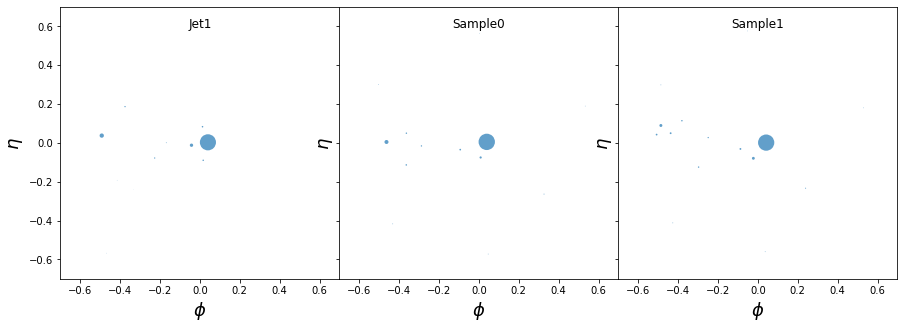

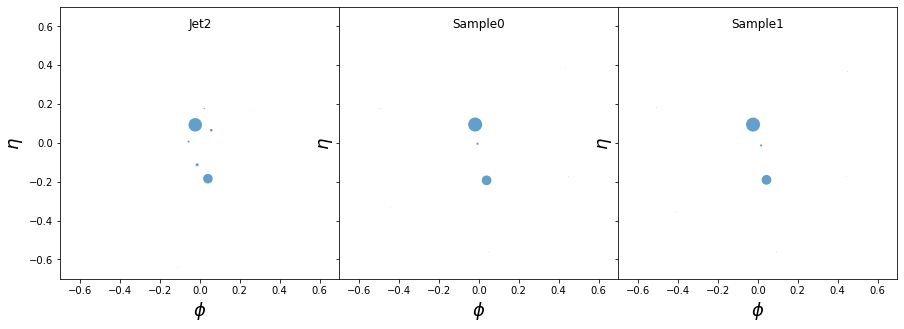

Latent space distributions in most important latent space directions


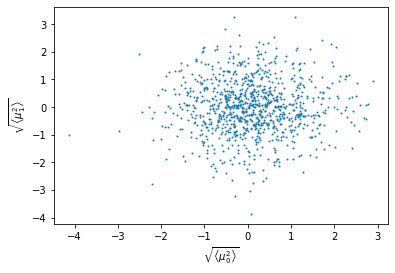

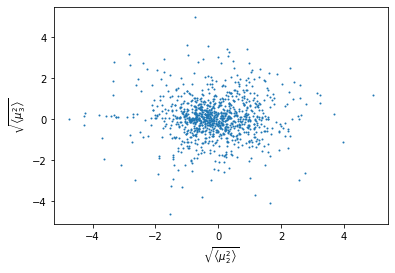

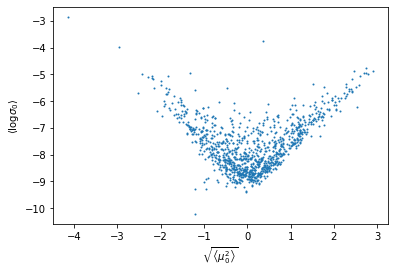

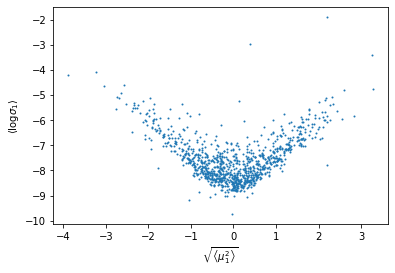

Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond 

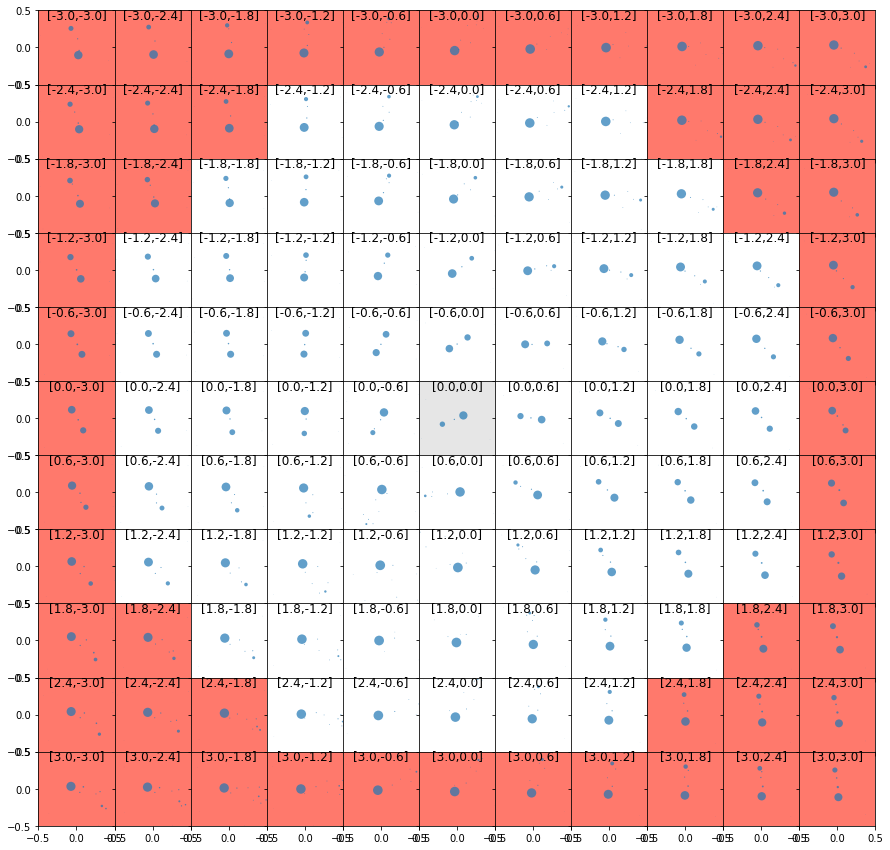

Next two latent directions. It seems that these describe a third emission. Radius in this plane is something like three-jettiness (2-jetty in the middle, three-jetty towards rim), and the angle in the plane represents the direction of the third emission.


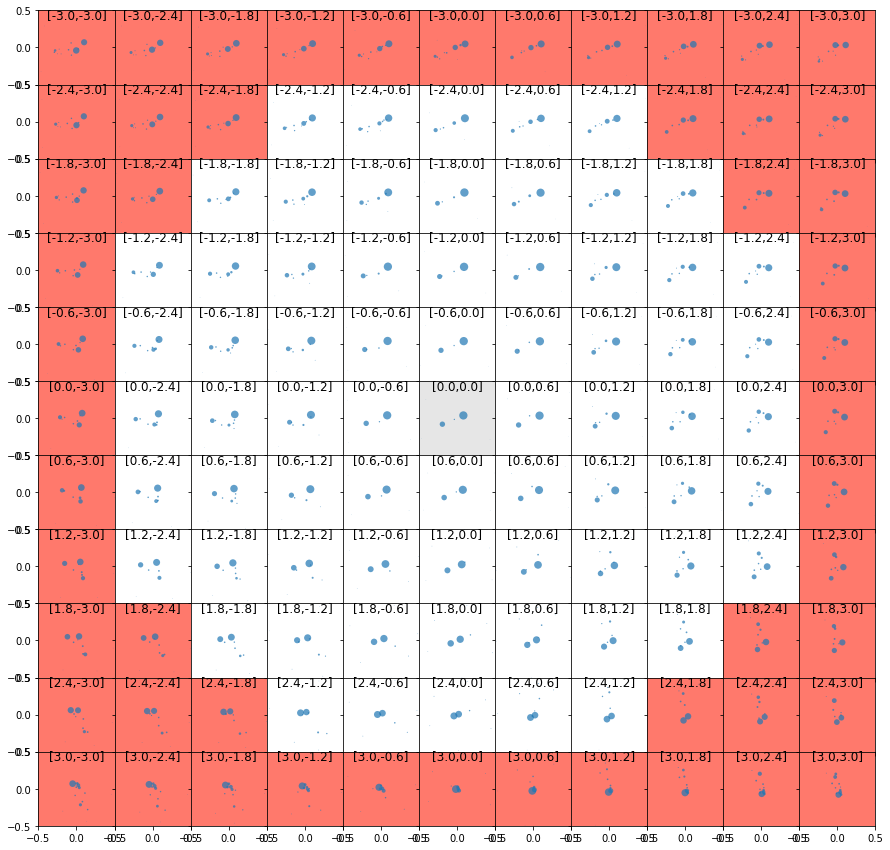

In [446]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_601_0.005.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

vae.beta.assign(5e-3)
result = vae.test_step([valid_x[:2000].astype(np.float32),valid_y[:2000].astype(np.float32)])

print("Loss:", "{:.02e}".format(result['loss'].numpy()))
print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
print("KL loss:", result['KL loss'].numpy())

print()

print("Epoch 601, beta = 5e-3")
print("I deleted a lot of the early model files to save space, so we get to see the NN after already a lot of training")
print("At this point, the NN understands four latent directions, as seen in the plots below")

print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

print("Jet sample plots. Left = original jet. Middle and right: two vae samples")
plot_jets(outs_array,R=0.05,size=300)

print("Latent space distributions in most important latent space directions")
_, z_mean, z_log_var, z = outs_array[0]

plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()
plt.scatter(z_mean[:,sort_kl[2]],z_mean[:,sort_kl[3]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_2^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_3^2 \right\rangle}$')
plt.show()

plt.scatter(z_mean[:,sort_kl[0]],z_log_var[:,sort_kl[0]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_0 \right\rangle$')
plt.show()
plt.scatter(z_mean[:,sort_kl[1]],z_log_var[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_1 \right\rangle$')
plt.show()

print("Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond to latent points that are close in the latent space, except at the rim of the disk where a small change in real space can take you straight to the opposite edge of the disk. As the resolution of the VAE gets finer and finer, this affects a smaller and smaller annulus of jets around the rim of the disk.")

narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


print("Next two latent directions. It seems that these describe a third emission. Radius in this plane is something like three-jettiness (2-jetty in the middle, three-jetty towards rim), and the angle in the plane represents the direction of the third emission.")
codes = np.zeros((narray**2,128))
dirs = [2,3]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.025)
        x=codes[narray*i+j,sort_kl[2]]
        y=codes[narray*i+j,sort_kl[3]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

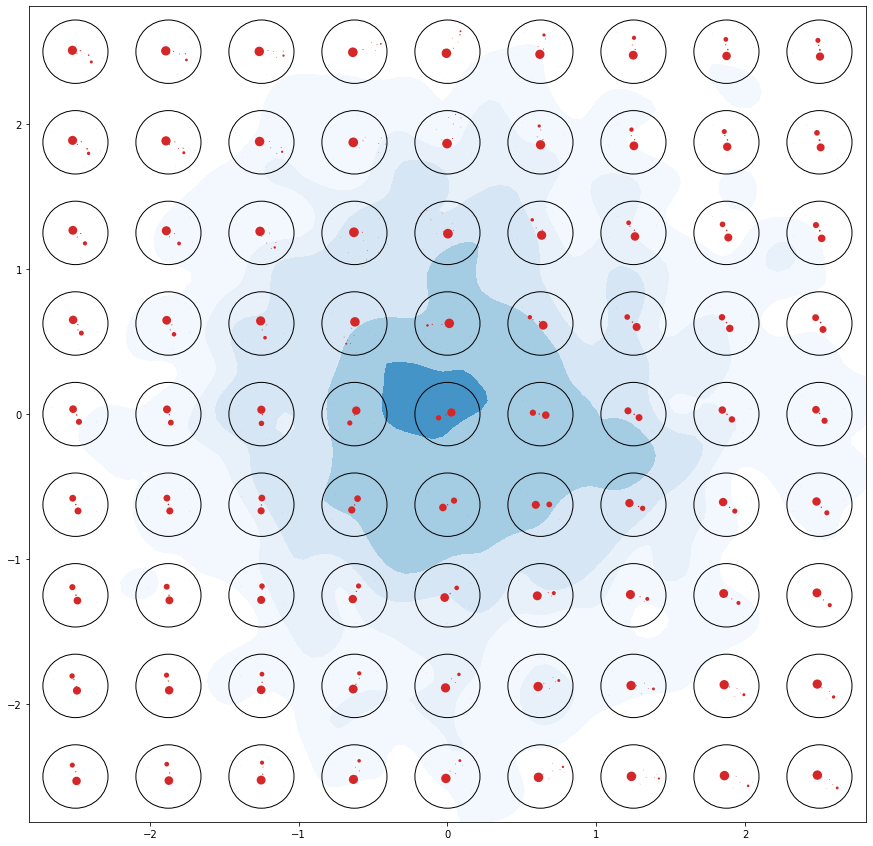

In [414]:
outs_array = [vae.predict(valid_x[:10000]) for j in range(0)]

narray = 9
lim = 2.5
codes = np.zeros((narray**2,128))

dirs = [1,0]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

# fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)
fig = plt.figure(figsize=[15,15])

circles = [[plt.Circle((i*2/(narray-1)*lim-lim, j*2/(narray-1)*lim-lim), 0.7/(narray-1)*lim,
                       color='black',#[0.8,0.8,0.8],
                       fill=False) for j in range(narray)] for i in range(narray)]

this = gaussian_kde([z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]]],bw_method=0.15)
xmin=-3.1
xmax=3.1
ymin=-3.1
ymax=3.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(this(positions).T, X.shape)
plt.contourf(np.rot90(X),np.rot90(Y),np.rot90(Z),[0.01,0.03,0.05,0.1,0.2,0.3],cmap='Blues',
             vmax=0.4)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.075)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        
        

        #         if np.square(x) + np.square(y) > np.square(2.7):
#             ax[i,j].set_facecolor('xkcd:salmon')
#         if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
#             ax[i,j].set_facecolor('xkcd:salmon')
        plt.scatter((phis + 2.*i)/(narray-1)*lim-lim, (etas+2.*j)/(narray-1)*lim-lim,
                    s = pts*100, alpha = 1.,linewidths=0,color='tab:red')

        plt.gcf().gca().add_artist(circles[i][j])
#         ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',

#         ax[j,i].set_aspect('equal')

# ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.xlim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])
plt.ylim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
plt.show()

## Epoch 643, beta = 0.003

NN doesn't learn new directions, but existing directions are recorded more precisely (points go right in plot below)

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


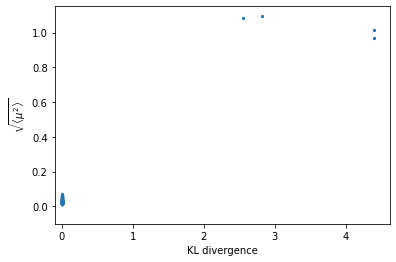

In [196]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_643_0.003.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch 722, beta = 0.001

Epoch 722, beta = 0.001
NN learns two new directions, but the existing directions start to get messed up a bit.
KL divergences plot. x axis is ~ log(resolution) for resolution << 1
After reducing beta by a couple of steps, model is no longer as well regulated/annealed, as indicated by the points going far above 1 on the y axis. It is not super important, but careful annealing tends to bring these back down to 1.


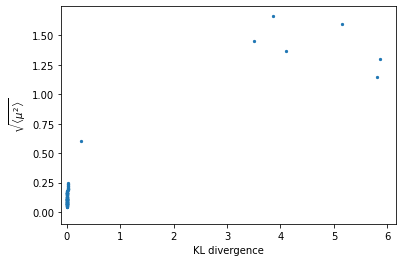

Latent space distributions in most important latent space directions. Can see again no longer regulated, distributions are departing from the standard Gaussian prior.


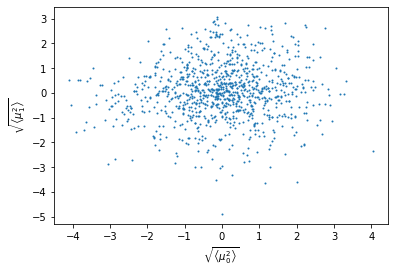

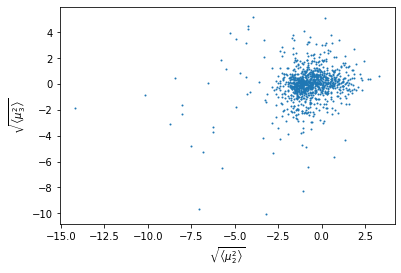

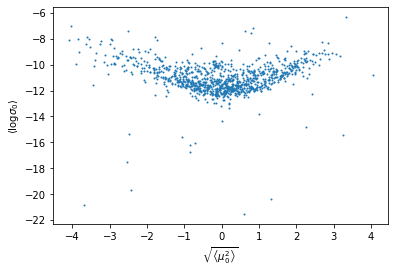

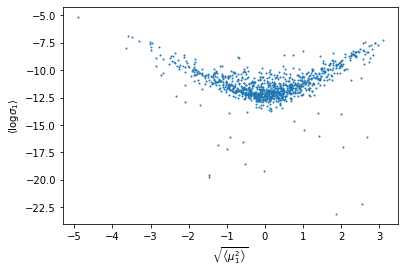

First four latent directions seem to still be doing mostly the same thing as before
Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, b

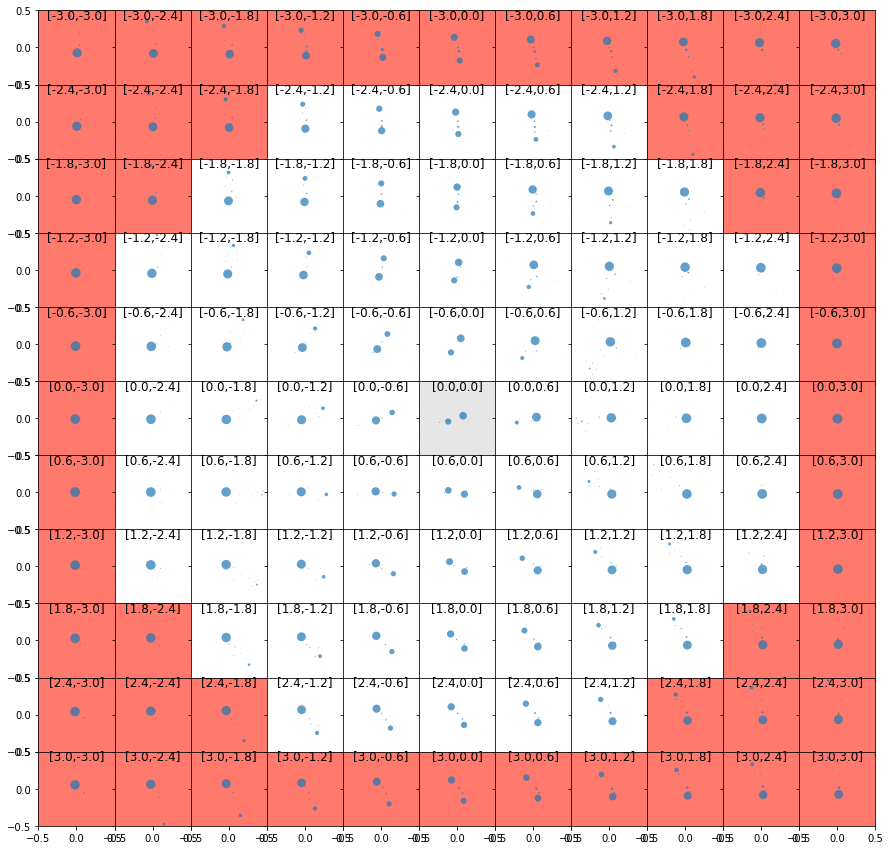

Next two latent directions. It seems that these describe a third emission. Radius in this plane is something like three-jettiness (2-jetty in the middle, three-jetty towards rim), and the angle in the plane represents the direction of the third emission.


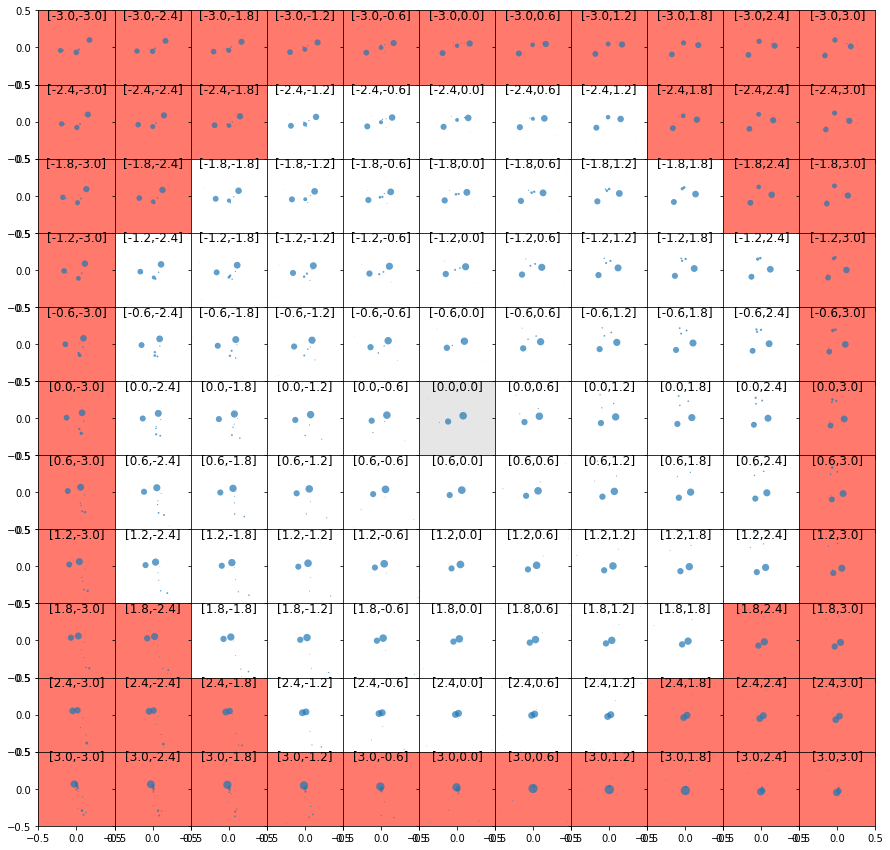

In [199]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_722_0.001.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

print("Epoch 722, beta = 0.001")
print("NN learns two new directions, but the existing directions start to get messed up a bit.")

print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
print("After reducing beta by a couple of steps, model is no longer as well regulated/annealed, as indicated by the points going far above 1 on the y axis. It is not super important, but careful annealing tends to bring these back down to 1.")
sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

# print("Jet sample plots. Left = original jet. Middle and right: two vae samples")
# plot_jets(outs_array,R=0.05,size=300)

print("Latent space distributions in most important latent space directions. Can see again no longer regulated, distributions are departing from the standard Gaussian prior.")
_, z_mean, z_log_var, z = outs_array[0]

plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()
plt.scatter(z_mean[:,sort_kl[2]],z_mean[:,sort_kl[3]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_2^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_3^2 \right\rangle}$')
plt.show()

plt.scatter(z_mean[:,sort_kl[0]],z_log_var[:,sort_kl[0]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_0 \right\rangle$')
plt.show()
plt.scatter(z_mean[:,sort_kl[1]],z_log_var[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_1 \right\rangle$')
plt.show()

print("First four latent directions seem to still be doing mostly the same thing as before")

print("Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond to latent points that are close in the latent space, except at the rim of the disk where a small change in real space can take you straight to the opposite edge of the disk. As the resolution of the VAE gets finer and finer, this affects a smaller and smaller annulus of jets around the rim of the disk.")

narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


print("Next two latent directions. It seems that these describe a third emission. Radius in this plane is something like three-jettiness (2-jetty in the middle, three-jetty towards rim), and the angle in the plane represents the direction of the third emission.")
codes = np.zeros((narray**2,128))
dirs = [2,3]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.025)
        x=codes[narray*i+j,sort_kl[2]]
        y=codes[narray*i+j,sort_kl[3]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Epoch '600', beta = 0.0005

Sometimes my epoch numbers get messed up. This is really tens of epochs after the last results, but the epoch number has been reset to 600 due to dumb mistake.

The six existing directions are getting a bit mixed up. A bunch of new directions are trying to get involved in the bottom right

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


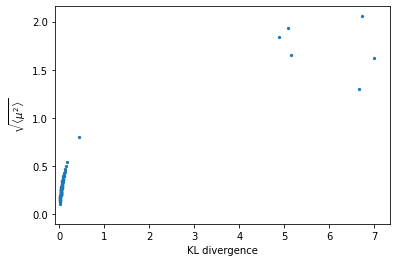

In [197]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_600_0.0005.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '661', beta = 0.0003

New directions continue to try and get a piece of the action in bottom left, very disorganized

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


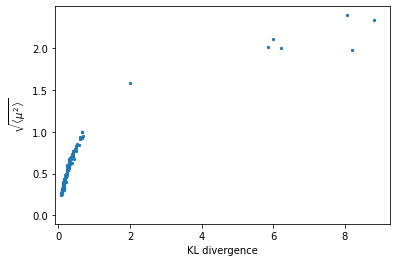

In [200]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_661_0.0003.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '755', beta = 0.0001

Chaos in bottom right. At this point, there is an increased danger of training instabilities and nans. I should start increasing beta at this point.

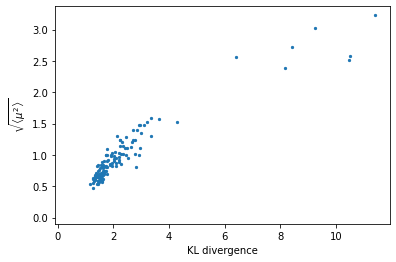

In [201]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_755_0.0001.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '813', beta = 1.9e-4

Chaos in bottom right. At this point, there is an increased danger of training instabilities and nans. I should start increasing beta at this point.

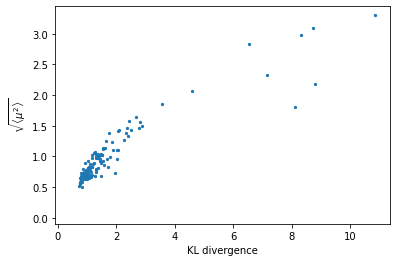

In [204]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_813_1.9e-04.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '885', beta = 3.5e-4

Chaos in bottom right. At this point, there is an increased danger of training instabilities and nans. I should start increasing beta at this point.

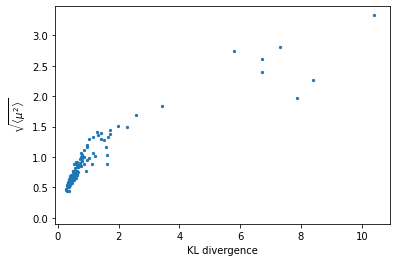

In [205]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_885_3.5e-04.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '919', beta = 6.7e-4

Chaos in bottom right. At this point, there is an increased danger of training instabilities and nans. I should start increasing beta at this point.

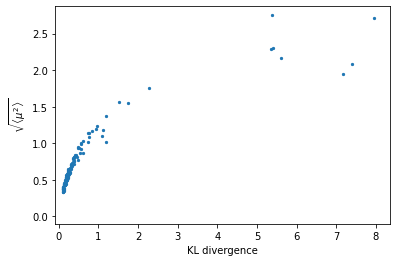

In [206]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_919_6.7e-04.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '937', beta = 1.3e-3

Compare with Epoch 722, beta = 0.001. Then there were six well described directions (large KL), one poorly described, and a jumble in bottom left. Now there are 7 well described, and quite a few around KL=1.

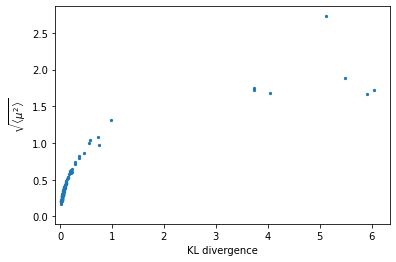

In [207]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_937_1.3e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '998', beta = 4.4e-3

Now we are going to skip bunches of beta steps to reduce the number of plots.

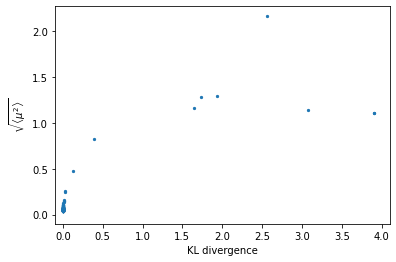

In [210]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_998_4.4e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '1109', beta = 1.6e-2

Very sexy, this is what a well annealed vae looks like. Basically expect mu^2 + sigma^2 = 1, where KL ~ - log(sigma^2) for small sigma, and ~ sigma^2 - 1 for large sigma (sigma goes to 1 for KL -> 0).

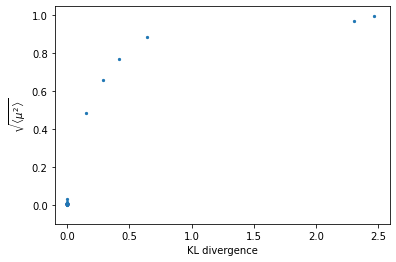

In [409]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_1109_1.6e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

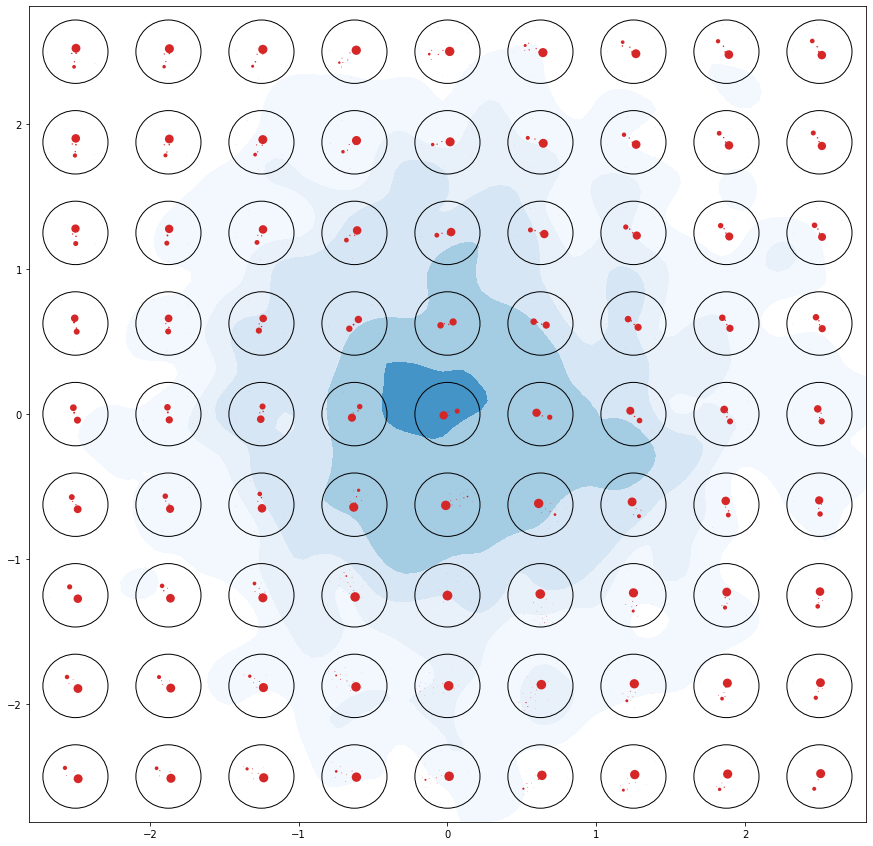

In [412]:
outs_array = [vae.predict(valid_x[:10000]) for j in range(0)]

narray = 9
lim = 2.5
codes = np.zeros((narray**2,128))

dirs = [1,0]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

# fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)
fig = plt.figure(figsize=[15,15])

circles = [[plt.Circle((i*2/(narray-1)*lim-lim, j*2/(narray-1)*lim-lim), 0.7/(narray-1)*lim,
                       color='black',#[0.8,0.8,0.8],
                       fill=False) for j in range(narray)] for i in range(narray)]

this = gaussian_kde([z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]]],bw_method=0.15)
xmin=-3.1
xmax=3.1
ymin=-3.1
ymax=3.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(this(positions).T, X.shape)
plt.contourf(np.rot90(X),np.rot90(Y),np.rot90(Z),[0.01,0.03,0.05,0.1,0.2,0.3],cmap='Blues',
             vmax=0.4)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.075)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        
        

        #         if np.square(x) + np.square(y) > np.square(2.7):
#             ax[i,j].set_facecolor('xkcd:salmon')
#         if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
#             ax[i,j].set_facecolor('xkcd:salmon')
        plt.scatter((phis + 2.*i)/(narray-1)*lim-lim, (etas+2.*j)/(narray-1)*lim-lim,
                    s = pts*100, alpha = 1.,linewidths=0,color='tab:red')

        plt.gcf().gca().add_artist(circles[i][j])
#         ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',

#         ax[j,i].set_aspect('equal')

# ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.xlim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])
plt.ylim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
plt.show()

## Epoch '1173', beta = 1.0e-1

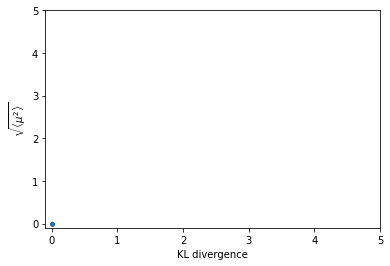

In [219]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_1173_1.0e-01.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,5],[-0.1,5])

## Epoch '1498', beta = 6.4e-3

Compare with epoch '1109', beta = 1.6e-2. Since beta is now smaller again, VAE should in principle be able to relearn what it knew then, but it is so far failing to do so. This is hysteresis (going up in beta gives different results from going down in beta)

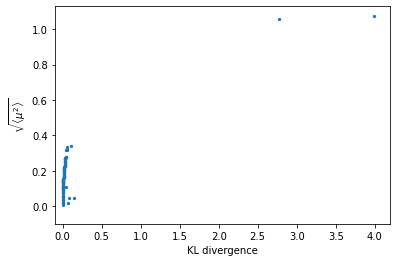

Latent space distributions in most important latent space directions


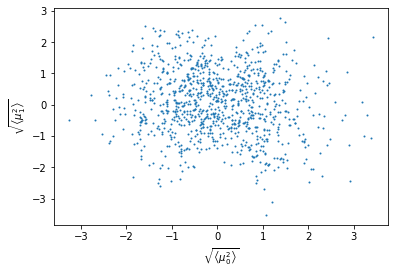

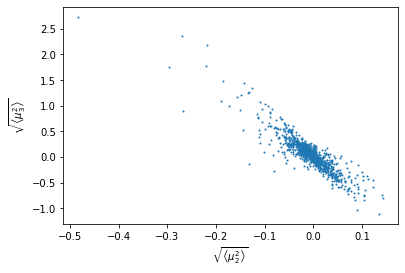

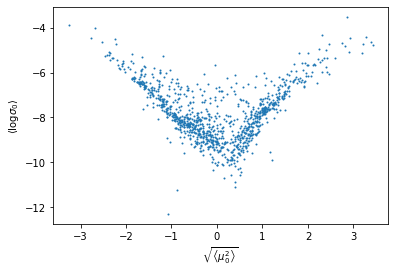

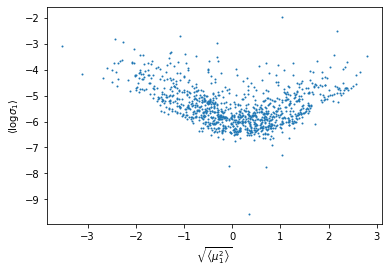

Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond 

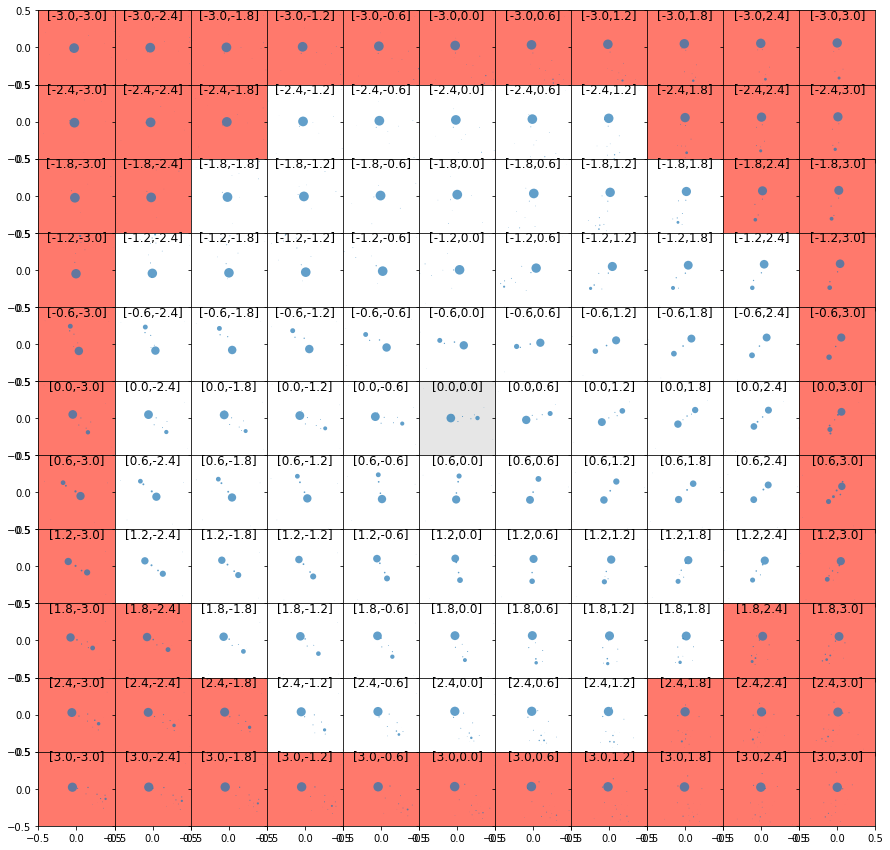

In [222]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_1498_6.4e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

print("Latent space distributions in most important latent space directions")
_, z_mean, z_log_var, z = outs_array[0]

plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()
plt.scatter(z_mean[:,sort_kl[2]],z_mean[:,sort_kl[3]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_2^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_3^2 \right\rangle}$')
plt.show()

plt.scatter(z_mean[:,sort_kl[0]],z_log_var[:,sort_kl[0]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_0 \right\rangle$')
plt.show()
plt.scatter(z_mean[:,sort_kl[1]],z_log_var[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_1 \right\rangle$')
plt.show()

print("Investigation of first two latent directions. This appears to be an inferior representation compared to epoch 601 at start of page. Would expect it to be fixed after downwards annealing.")
narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Epoch '1744', beta = 1.1e-3

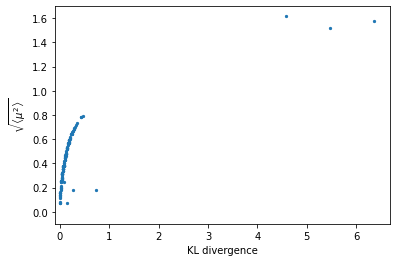

In [223]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_1744_1.1e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '2063', beta = 1.0e-4

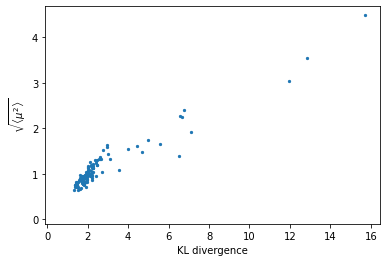

In [224]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_2063_1.0e-04.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '2366', beta = 1.0e-5

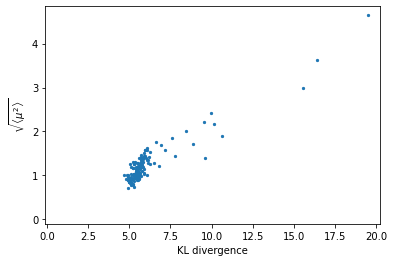

In [225]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_2366_1.0e-05.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '2548', beta = 1.0e-4

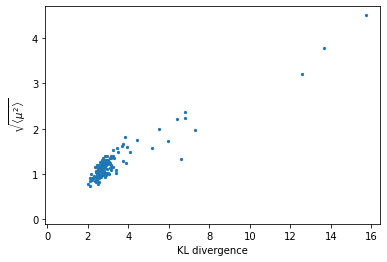

In [226]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_2548_1.0e-04.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '2874', beta = 1.1e-3

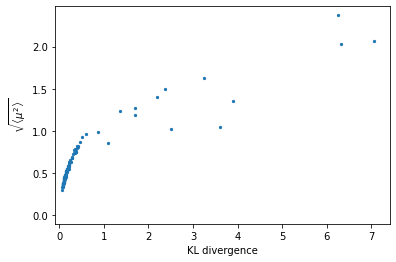

Loss: 7.94e+02
Recon loss: 8.83e-04
KL loss: 64.651436


In [440]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_2874_1.1e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

vae.beta.assign(1.1e-3)
result = vae.test_step([valid_x[:2000].astype(np.float32),valid_y[:2000].astype(np.float32)])

print("Loss:", "{:.02e}".format(result['loss'].numpy()))
print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
print("KL loss:", result['KL loss'].numpy())

## Epoch '2982', beta = 3.5e-3

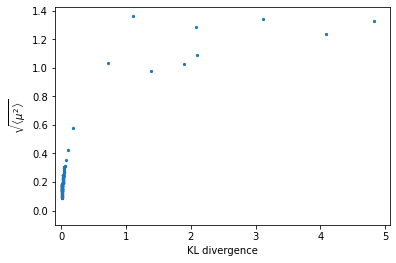

In [228]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_2982_3.5e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '3115', beta = 1.1e-2

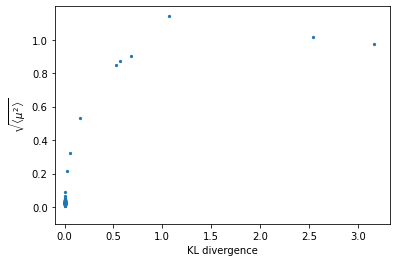

In [229]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3115_1.1e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '3196', beta = 3.7e-2

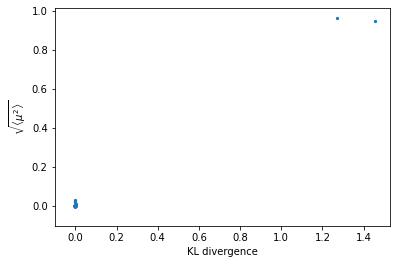

Latent space distributions in most important latent space directions


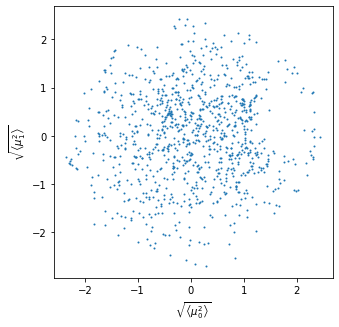

This is an alternative representation of the 2-prong W. This time, the kinematic sphere has been projected with the pole (theta = 0/pi) in the center of the plane, and the rim of the plane is the equator. The pole of the sphere is really at coordinates around [-0.6,0.6], somewhere in the region of the grey highlighted square.

 Since the equator of the sphere should have an identification between opposite points, but the mapping from data to latent space has to be one-to-one (or at least many-to-one), we can see that the fully balanced jets only occupy the left and bottom parts of the rim. Their opposite points are not populated. This also explains why the pole is located off-center in these coordinates.


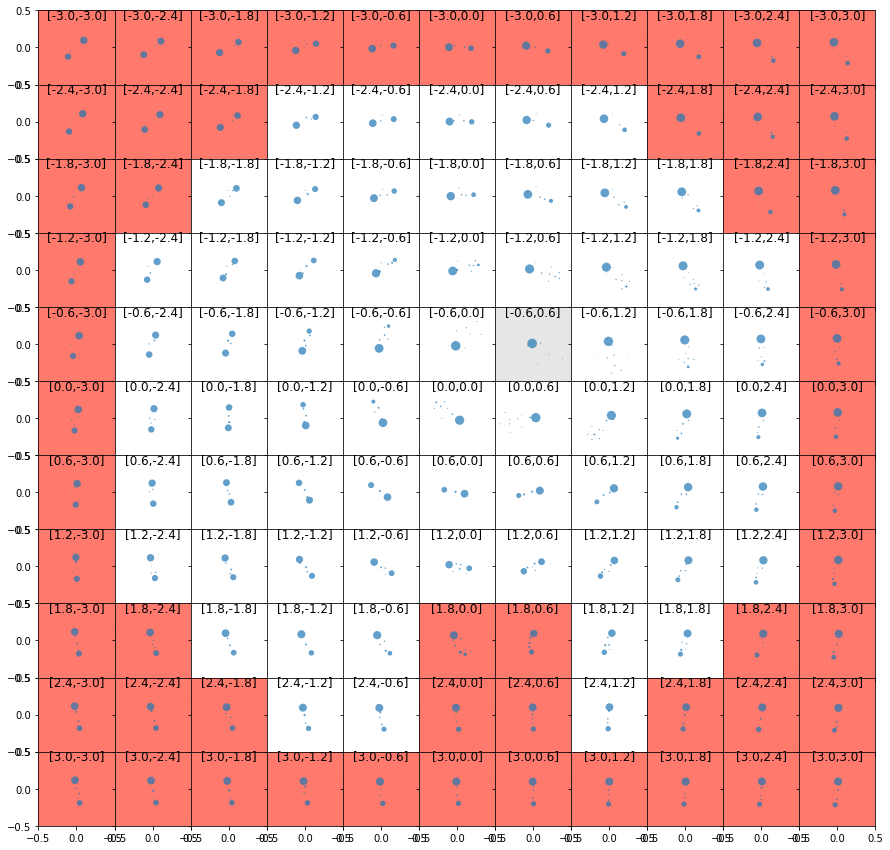

In [244]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3196_3.7e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

print("Latent space distributions in most important latent space directions")
_, z_mean, z_log_var, z = outs_array[0]

figure = plt.figure(figsize=[5,5])
plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()

print("This is an alternative representation of the 2-prong W. This time, the kinematic sphere has been projected with the pole (theta = 0/pi) in the center of the plane, and the rim of the plane is the equator. The pole of the sphere is really at coordinates around [-0.6,0.6], somewhere in the region of the grey highlighted square.")
print("\n Since the equator of the sphere should have an identification between opposite points, but the mapping from data to latent space has to be one-to-one (or at least many-to-one), we can see that the fully balanced jets only occupy the left and bottom parts of the rim. Their opposite points are not populated. This also explains why the pole is located off-center in these coordinates.")

narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')

ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

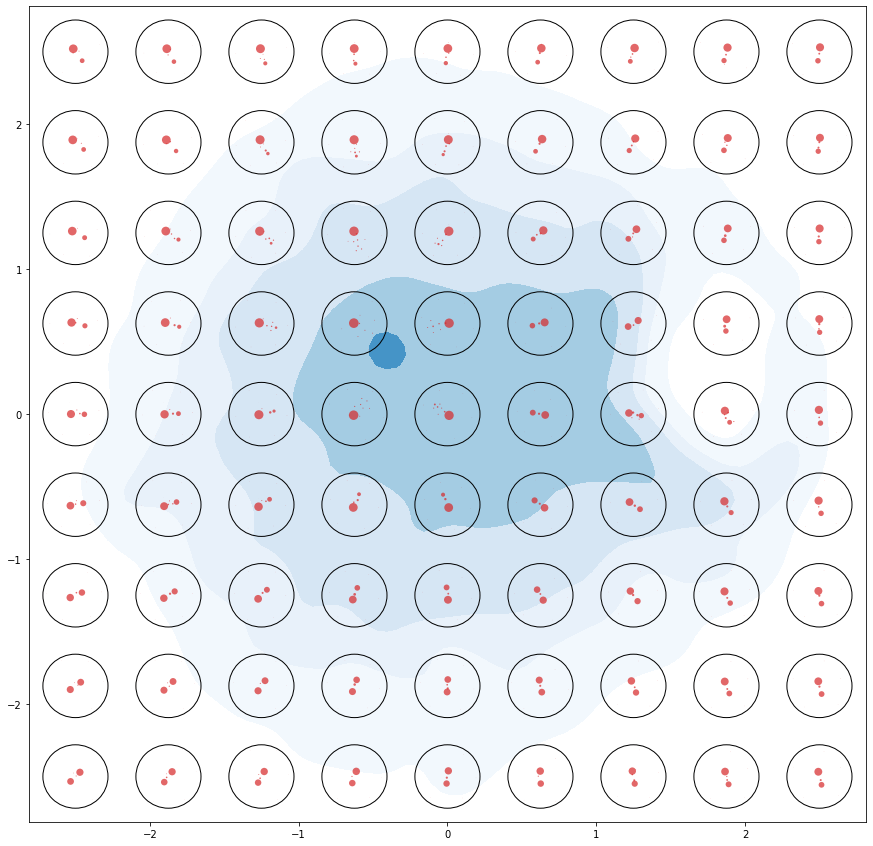

In [403]:
narray = 9
lim = 2.5
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

# fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)
fig = plt.figure(figsize=[15,15])

circles = [[plt.Circle((i*2/(narray-1)*lim-lim, j*2/(narray-1)*lim-lim), 0.7/(narray-1)*lim,
                       color='black',#[0.8,0.8,0.8],
                       fill=False) for j in range(narray)] for i in range(narray)]

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.075)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        
        
        this = gaussian_kde([z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]]],bw_method=0.15)
        xmin=-3.1
        xmax=3.1
        ymin=-3.1
        ymax=3.1
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(this(positions).T, X.shape)
        plt.contourf(np.rot90(X),np.rot90(Y),np.rot90(Z),[0.01,0.03,0.05,0.1,0.2,0.3],cmap='Blues',
                     zorder=-1,vmax=0.4)
        #         if np.square(x) + np.square(y) > np.square(2.7):
#             ax[i,j].set_facecolor('xkcd:salmon')
#         if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
#             ax[i,j].set_facecolor('xkcd:salmon')
        plt.scatter((phis + 2.*i)/(narray-1)*lim-lim, (etas+2.*j)/(narray-1)*lim-lim,
                    s = pts*100, alpha = 1.,linewidths=0,color='tab:red')

        plt.gcf().gca().add_artist(circles[i][j])
#         ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',

#         ax[j,i].set_aspect('equal')

# ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.xlim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])
plt.ylim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
plt.show()

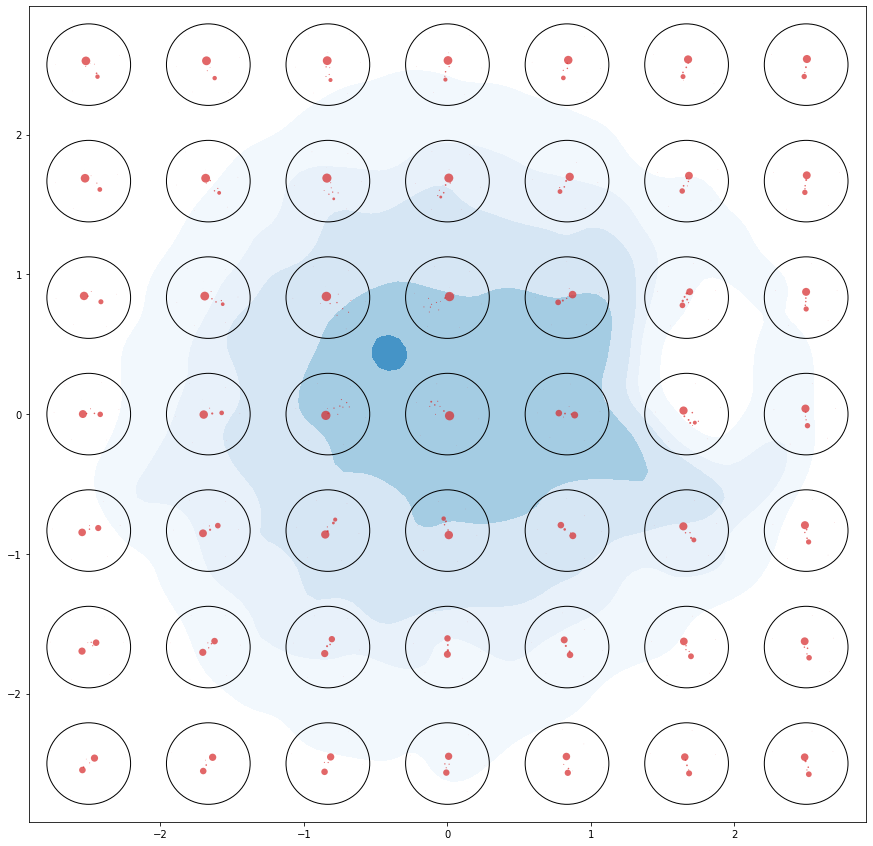

In [402]:
narray = 7
lim = 2.5
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

# fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)
fig = plt.figure(figsize=[15,15])

circles = [[plt.Circle((i*2/(narray-1)*lim-lim, j*2/(narray-1)*lim-lim), 0.7/(narray-1)*lim,
                       color='black',#[0.8,0.8,0.8],
                       fill=False) for j in range(narray)] for i in range(narray)]

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        
        
        this = gaussian_kde([z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]]],bw_method=0.15)
        xmin=-3.1
        xmax=3.1
        ymin=-3.1
        ymax=3.1
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(this(positions).T, X.shape)
        plt.contourf(np.rot90(X),np.rot90(Y),np.rot90(Z),[0.01,0.03,0.05,0.1,0.2,0.3],cmap='Blues',
                     zorder=-1,vmax=0.4)
        #         if np.square(x) + np.square(y) > np.square(2.7):
#             ax[i,j].set_facecolor('xkcd:salmon')
#         if np.square(x-2.) + np.square(y-0.3) < np.square(0.8):
#             ax[i,j].set_facecolor('xkcd:salmon')
        plt.scatter((phis + 2.*i)/(narray-1)*lim-lim, (etas+2.*j)/(narray-1)*lim-lim,
                    s = pts*100, alpha = 0.7,linewidths=0,color='tab:red')

        plt.gcf().gca().add_artist(circles[i][j])
#         ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',

#         ax[j,i].set_aspect('equal')

# ax[int((narray-1)/2)-1,int((narray-1)/2)+1].set_facecolor([0.9,0.9,0.9])

plt.xlim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])
plt.ylim([(-0.5-(narray-1)/2)*lim/((narray-1)/2),(narray-0.5-(narray-1)/2)*lim/((narray-1)/2)])

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
plt.show()

## Epoch '3228', beta = 6.7e-2

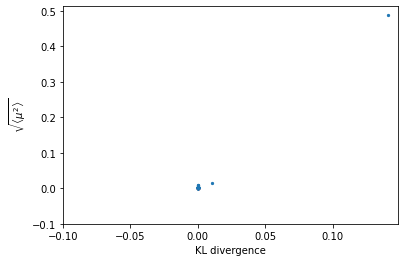

Investigation of first two latent directions.


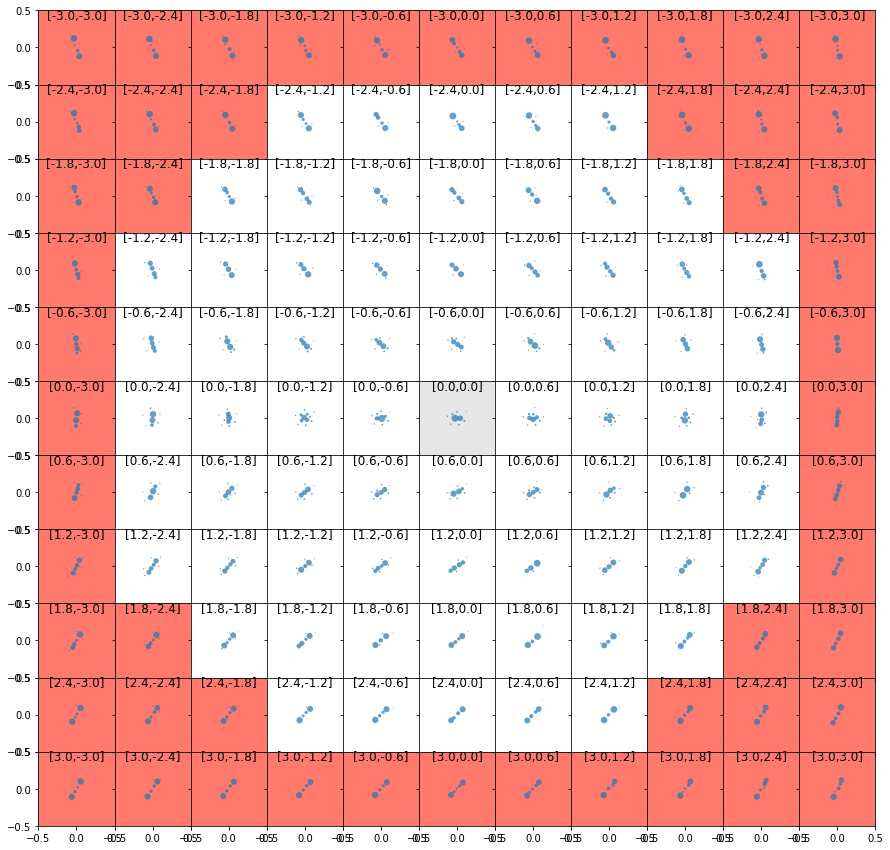

In [240]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3228_6.7e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

print("Investigation of first two latent directions.")

narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Epoch '3279', beta = 3.7e-2

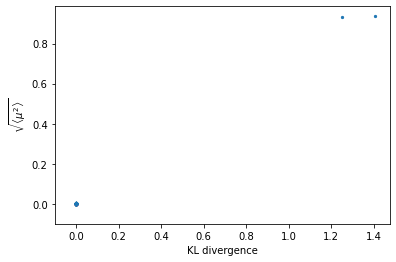

Investigation of first two latent directions.


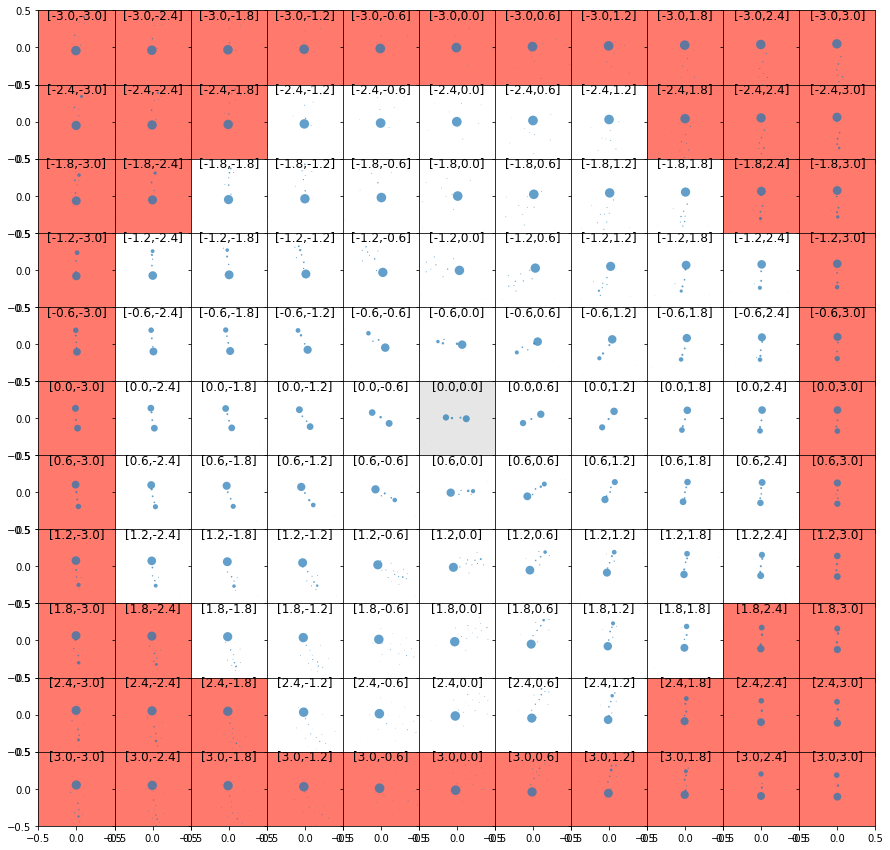

In [239]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3279_3.7e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

print("Investigation of first two latent directions.")

narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Epoch '3279', beta = 3.7e-2

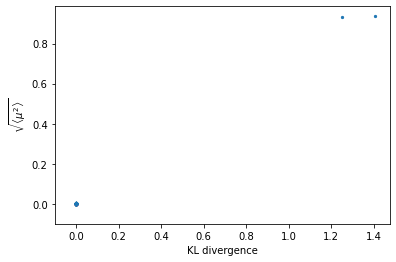

Latent space distributions in most important latent space directions


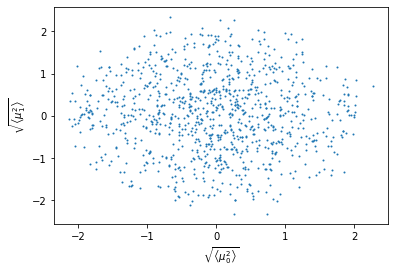

Investigation of first two latent directions. This appears to be an inferior representation compared to epoch 601 at start of page. Would expect it to be fixed after downwards annealing.


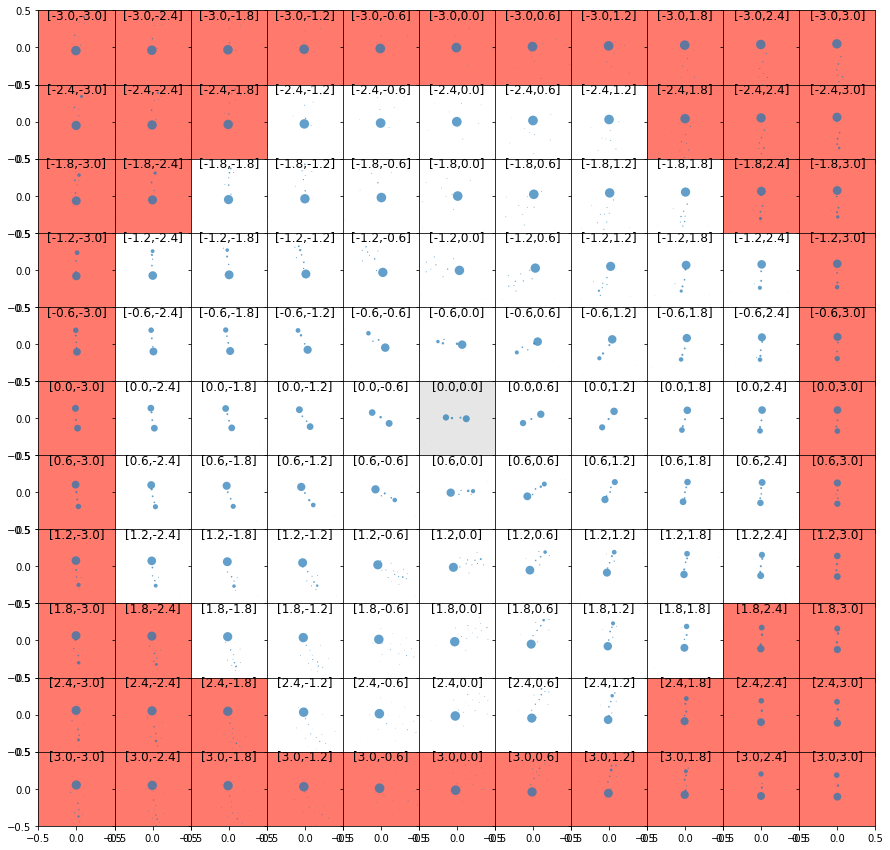

In [238]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3279_3.7e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]


sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

print("Latent space distributions in most important latent space directions")
_, z_mean, z_log_var, z = outs_array[0]

plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()

print("Investigation of first two latent directions. This appears to be an inferior representation compared to epoch 601 at start of page. Would expect it to be fixed after downwards annealing.")
narray = 11
lim = 3.0
codes = np.zeros((narray**2,128))

dirs = [0,1]

for i in range(narray):
    for j in range(narray):
        codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
        codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

decoded = decoder.predict(codes)

fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

for i in range(narray):
    for j in range(narray):
        outjet = decoded[narray*i+j,:,1:]
        weights = decoded[narray*i+j,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
        x=codes[narray*i+j,sort_kl[dirs[0]]]
        y=codes[narray*i+j,sort_kl[dirs[1]]]
        if np.square(x) + np.square(y) > np.square(2.7):
            ax[i,j].set_facecolor('xkcd:salmon')
        ax[i,j].scatter(phis, etas, s = pts*100, alpha = 0.7,linewidths=0)
        ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(-0.5,0.5)
        ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                         y=0.8)
#         ax[j,i].set_aspect('equal')
ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Epoch '3383', beta = 1.4e-2

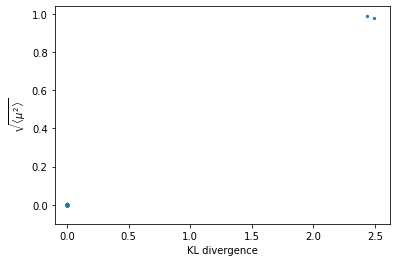

In [415]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3383_1.4e-02.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '3717', beta = 1.2e-3

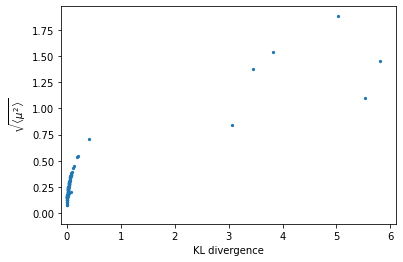

Recon loss: 1.26e-03
KL loss: 31.286007


In [437]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3717_1.2e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

result = vae.test_step([valid_x[:2000].astype(np.float32),valid_y[:2000].astype(np.float32)])
print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
print("KL loss:", result['KL loss'].numpy())

## Epoch '3957', beta = 1.6e-4

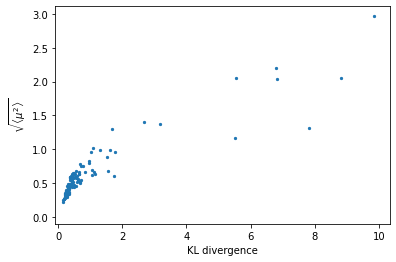

In [418]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3957_1.6e-04.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(1)]

sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

## Epoch '3971', beta = 1.0e-3

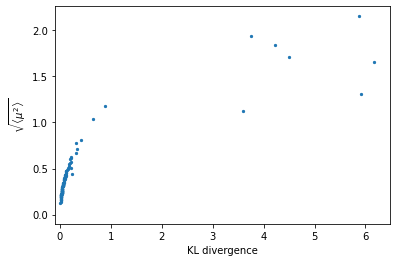

Loss: 8.74e+02
Recon loss: 1.00e-03
KL loss: 44.97502


In [441]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_end_3971_1.0e-03.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(1)]

sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

vae.beta.assign(1.1e-3)
result = vae.test_step([valid_x[:2000].astype(np.float32),valid_y[:2000].astype(np.float32)])

print("Loss:", "{:.02e}".format(result['loss'].numpy()))
print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
print("KL loss:", result['KL loss'].numpy())

In [89]:
import numpy as np
beta_range = np.logspace(-1,-4,16)

In [133]:
betas = np.zeros(0)
beta_range = np.logspace(-1,-4,31)
betas = np.logspace(-2,-1,6)
for i in range(6):
    betas = np.append(betas,np.flip(beta_range[i:i+16:2]))
    betas = np.append(betas,beta_range[i+2:i+16:2])
for i in range(3,10):
    betas = np.append(betas,np.flip(beta_range[2*i:2*i+16:2]))
    betas = np.append(betas,beta_range[2*i+2:2*i+16:2])

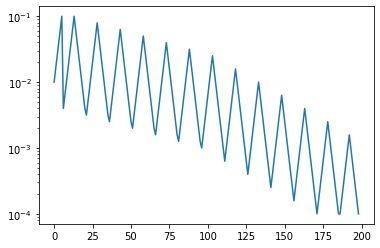

In [134]:
plt.plot(betas)
plt.semilogy()
plt.show()

In [135]:
train_x

array([[[ 7.03576131e-01, -3.34484992e-02,  9.98576390e-01,
          5.33403520e-02, -3.50873864e-01],
        [ 2.16898474e-01,  8.66073898e-02,  9.80831683e-01,
         -1.94856893e-01, -1.52395357e+00],
        [ 1.89505373e-02,  1.77887299e-01,  9.68941504e-01,
          2.47290037e-01, -3.94700716e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.84206807e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.84206807e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.84206807e+01]],

       [[ 7.14214254e-01, -2.50066694e-02,  9.97274380e-01,
          7.37821911e-02, -3.35418855e-01],
        [ 2.24035796e-01,  9.24063312e-02,  9.71018769e-01,
         -2.39003241e-01, -1.49155553e+00],
        [ 2.61467942e-02, -6.69654883e-02,  9.99915195e-01,
         -1.30231432e-02, -3.63672981e+00],
        ...,
        [ 0.00000000e+00,  0.0000000

In [70]:
np.append(beta_range,[1,2,3])

array([1.00000000e-01, 7.94328235e-02, 6.30957344e-02, 5.01187234e-02,
       3.98107171e-02, 3.16227766e-02, 2.51188643e-02, 1.99526231e-02,
       1.58489319e-02, 1.25892541e-02, 1.00000000e-02, 7.94328235e-03,
       6.30957344e-03, 5.01187234e-03, 3.98107171e-03, 3.16227766e-03,
       2.51188643e-03, 1.99526231e-03, 1.58489319e-03, 1.25892541e-03,
       1.00000000e-03, 7.94328235e-04, 6.30957344e-04, 5.01187234e-04,
       3.98107171e-04, 3.16227766e-04, 2.51188643e-04, 1.99526231e-04,
       1.58489319e-04, 1.25892541e-04, 1.00000000e-04, 1.00000000e+00,
       2.00000000e+00, 3.00000000e+00])

In [71]:
beta_range

array([0.1       , 0.07943282, 0.06309573, 0.05011872, 0.03981072,
       0.03162278, 0.02511886, 0.01995262, 0.01584893, 0.01258925,
       0.01      , 0.00794328, 0.00630957, 0.00501187, 0.00398107,
       0.00316228, 0.00251189, 0.00199526, 0.00158489, 0.00125893,
       0.001     , 0.00079433, 0.00063096, 0.00050119, 0.00039811,
       0.00031623, 0.00025119, 0.00019953, 0.00015849, 0.00012589,
       0.0001    ])